# Donors Choose - Data Exploration
## David Modjeska
## Kaggle Competition
## March-April 2018

In [273]:
import itertools
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import xgboost as xgb

from datetime import datetime, date, time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.utils import shuffle

%matplotlib inline
from IPython.display import Image, display, HTML

In [274]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

In [275]:
from donors_choose_info import *

# Load Data

In [276]:
# helper function to load data
def my_load_data(filename):
    
    # read data
    data = pd.read_csv(filename)

    # drop extra columns
    data = data.drop(['project_submit_datetime', 'teacher_prefix', 'gender', 'state'], axis = 1)
    
#     drop_cols = [col for col in data.columns if re.search('[Z]', col)]
#     data = data.drop(drop_cols, axis = 1)
    
    my_display_df(data.head())
    
    return(data)

In [277]:
# load full training data
full_training_data = my_load_data('processed_train_data.csv')
full_training_data = full_training_data.drop('id', axis = 1)

V0,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,W0,W1,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W2,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W3,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W4,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W5,W50,W51,W52,W53,W54,W55,W56,W57,W58,W59,W6,W60,W61,W62,W63,W64,W65,W66,W67,W68,W69,W7,W70,W71,W72,W73,W74,W75,W76,W77,W78,W79,W8,W80,W81,W82,W83,W84,W85,W86,W87,W88,W89,W9,W90,W91,W92,W93,W94,W95,W96,W97,W98,W99,X0,X1,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X2,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X3,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X4,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X5,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X6,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X7,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y0,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,Y19,Y2,Y20,Y21,Y22,Y23,Y24,Y25,Y26,Y27,Y28,Y29,Y3,Y30,Y31,Y32,Y33,Y34,Y35,Y36,Y37,Y38,Y39,Y4,Y40,Y41,Y42,Y43,Y44,Y45,Y46,Y47,Y48,Y49,Y5,Y50,Y51,Y52,Y53,Y54,Y55,Y56,Y57,Y58,Y59,Y6,Y60,Y61,Y62,Y63,Y64,Y65,Y66,Y67,Y68,Y69,Y7,Y70,Y71,Y72,Y73,Y74,Y75,Y76,Y77,Y78,Y79,Y8,Y80,Y81,Y82,Y83,Y84,Y85,Y86,Y87,Y88,Y89,Y9,Y90,Y91,Y92,Y93,Y94,Y95,Y96,Y97,Y98,Y99,Z0,Z1,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z2,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z3,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,Z38,Z39,Z4,Z40,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z5,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59,Z6,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z7,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z8,Z80,Z81,Z82,Z83,Z84,Z85,Z86,Z87,Z88,Z89,Z9,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,app_sci,applied_learning,care,care_and_hunger,civ_and_gov,college_and_career,comm_serve,cur_price_per_total_apps,date_index,day_of_month,day_of_week,early_dev,econ,env_sci,esl,essay_1_sentiment_polarity,essay_1_sentiment_subjectivity,essay_2_sentiment_polarity,essay_2_sentiment_subjectivity,extracurricular,fin_lit,grade_category,gym_and_fit,health_and_life_sci,health_and_sports,health_and_well,hist_and_civ,hist_and_geo,hour_of_day,id,languages,lit,lit_and_lang,lit_and_writing,math,math_and_sci,median_word_len_1,median_word_len_2,median_word_len_res_descrip,median_word_len_res_sum,median_word_len_title,month_of_year,music,num_categories,num_chars_1,num_chars_2,num_chars_res_descrip,num_chars_res_sum,num_chars_title,num_punctuations_1,num_punctuations_2,num_stopwords_1,num_stopwords_2,num_subcategories,num_unique_words_1,num_unique_words_2,num_unique_words_res_descrip,num_unique_words_res_sum,num_unique_words_title,num_words_1,num_words_2,num_words_res_descrip,num_words_res_sum,num_words_title,nutrition,other,parent_involve,perform_arts,project_is_approved,project_max_price,project_max_quantity,project_mean_price,project_mean_quantity,project_min_price,project_min_quantity,project_price,project_price_per_item,project_quantity,project_resource_summary_sentiment_polarity,project_resource_summary_sentiment_subjectivity,project_title_sentiment_polarity,project_title_sentiment_subjectivity,res_description_sentiment_polarity,res_description_sentiment_subjectivity,soc_sci,special_needs,special_needs_2,teacher_max_price,teacher_max_quantity,teacher_mean_price,teacher_mean_quantity,teacher_min_price,teacher_min_quantity,teacher_num_prev_posted_projs,teacher_price,teacher_price_per_item,teacher_quantity,team_sports,vis_arts,warmth,year,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32,S33,S34,S35,S36,S37,S38,S39,S40,S41,S42,S43,S44,S45,S46,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56,P0,P1,P2,P3,P4,P5,G0,G1,G2,G3,G4,G5
-0.102617,-0.064140,-0.170668,-0.034246,0.

In [278]:
X_full = full_training_data.drop('project_is_approved', axis = 1)
y_full = full_training_data.project_is_approved

In [279]:
## split data into training vs. validation

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size = 0.66,
                                                     random_state = 0)

print('Training X shape ' + str(X_train.shape))
print('Validation X shape ' + str(X_valid.shape))
print()
print('Training y shape ' + str(y_train.shape))
print('Validation y shape ' + str(y_valid.shape))

/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training X shape (120172, 668)
Validation X shape (61908, 668)

Training y shape (120172,)
Validation y shape (61908,)


In [280]:
## split training data into tuning and extra

X_tune, X_extra, y_tune, y_extra = train_test_split(X_train, y_train, train_size = 0.50)

print('Tuning X shape ' + str(X_tune.shape))
print('Extra X shape ' + str(X_extra.shape))
print()
print('Tuning y shape ' + str(y_tune.shape))
print('Extra y shape ' + str(y_extra.shape))

/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Tuning X shape (60086, 668)
Extra X shape (60086, 668)

Tuning y shape (60086,)
Extra y shape (60086,)


# Define Helper Functions

In [281]:
# helper function to visualize a confusion matrix
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black",
                size = 12)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [282]:
def display_confusion_matrix(true_y, predicted_y):
    cm = confusion_matrix(true_y, predicted_y)
    fig = plt.figure(figsize = (4, 4))
    plot_confusion_matrix(cm = cm, classes = [0, 1])
    plt.show()

In [283]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba[:, 1])
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (4.5, 4.5))
    plt.title('ROC Curve (Class = 1)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.3f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

In [284]:
# helper function to do cross-validated grid search, to identify optimal parameter values
def grid_search_model(model, X, y, parm_1_name, parm_1_values, parm_2_name = None, 
                      parm_2_values = None): 
    
    # assemble parameters dictionary
    parameters = {parm_1_name : parm_1_values}
    if parm_2_name is not None:
        parameters[parm_2_name] = parm_2_values   
        
    # perform grid search
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 3, 
                        scoring = 'roc_auc', n_jobs = my_n_jobs, verbose = 2)  
    _ = grid.fit(X = X, y = y)    

    # display best score and parameters
    my_linespace()
    my_display('Best AUC:' +  str(round(grid.best_score_, 4)))
    my_display('Best ' + parm_1_name + ' = ' + str(grid.best_params_[parm_1_name]))
    if parm_2_name is not None:
        my_display('Best ' + parm_2_name + ' = ' + str(grid.best_params_[parm_2_name]))

In [285]:
def fit_score_one_model(model, X_train, y_train, X_valid, y_valid):
    _ = model.fit(X_train, y_train)
    valid_preds = model.predict_proba(X_valid)
    display_roc_curve(y_valid, valid_preds)
    display_confusion_matrix(y_valid, valid_preds[:, 1] > 0.5)

In [286]:
# adapted from http://www.agcross.com/2015/02/random-forests-in-python-with-scikit-learn/
def plot_importance(name, model, features):
    importances = model.feature_importances_[:50]
    indices = np.argsort(importances)

    plt.figure(figsize = (6, 12))
    plt.title(name + 'Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color = 'darkblue', align = 'center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [287]:
# calculate relative class weights
class_counts = y_train.value_counts()
my_scale_pos_weight = class_counts[0] / class_counts[1]
print('Relative weight of project rejections to approvals: ' + str(round(my_scale_pos_weight, 2)))

Relative weight of project rejections to approvals: 0.18


# Model Data

## XGB

### Validate Model

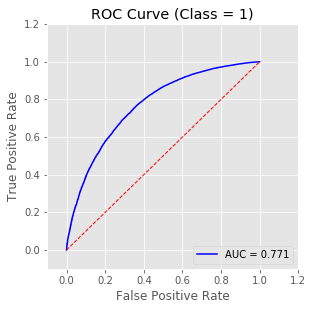

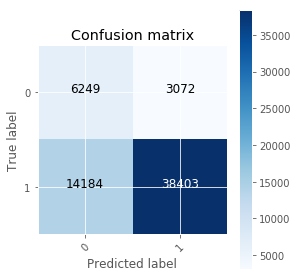

In [288]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = my_scale_pos_weight, 
                              seed = 82, 
                              nthread = my_n_jobs,
                              n_estimators = 400,
                              learning_rate = 0.08,
                              max_depth = 3,
                             reg_lambda = 0.11,
                             min_child_weight = 1) 

fit_score_one_model(xgb_model, X_train, y_train, X_valid, y_valid)

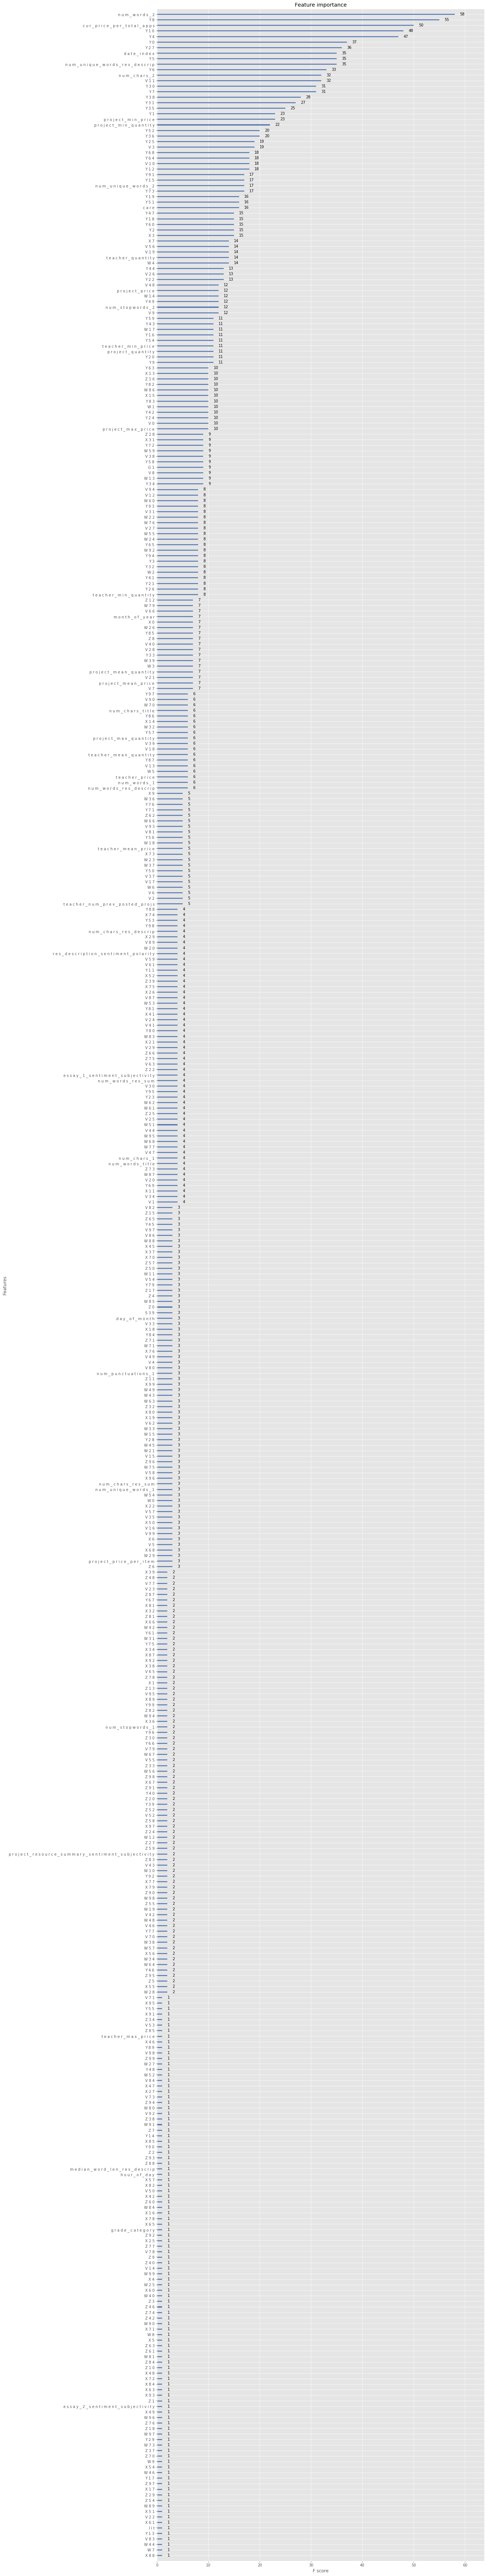

In [289]:
fig, ax = plt.subplots(figsize = (16, 128))
xgb.plot_importance(xgb_model, ax = ax)
plt.show()

In [290]:
## select features using threshold

selector = SelectFromModel(xgb_model, threshold = 0.003, prefit = True)
select_X_train = selector.transform(X_train)
select_X_valid = selector.transform(X_valid)
select_X_tune = selector.transform(X_tune)

print("Select X train shape:", select_X_train.shape)
print("Select X valid shape:", select_X_valid.shape)
print("Select X tune shape:", select_X_tune.shape)

Select X train shape: (120172, 86)
Select X valid shape: (61908, 86)
Select X tune shape: (60086, 86)


In [291]:
def my_create_xgb():
    return(
        xgb.XGBClassifier(scale_pos_weight = my_scale_pos_weight, 
                          seed = 82, 
                          nthread = my_n_jobs,
                          n_estimators = 400,
                          learning_rate = 0.1,
                          max_depth = 3,
                          min_child_weight = 1,
                          reg_lambda = 0.11,
                          subsample = 0.8,
                          reg_alpha = 10) 
    )

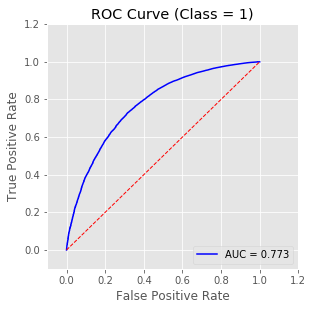

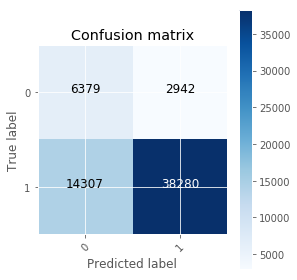

In [292]:
select_xgb_model = my_create_xgb()
fit_score_one_model(select_xgb_model, select_X_train, y_train, select_X_valid, y_valid)

### Tune Model

In [293]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                scale_pos_weight = my_scale_pos_weight)
# grid_search_model(tune_model, select_X_tune, y_tune, 'n_estimators', list(range(100, 1100, 100)))

In [294]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'learning_rate', np.arange(0.05, 0.3, 0.05))

In [295]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'learning_rate', np.arange(0.08, 0.12, 0.01))

In [296]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                learning_rate = 0.1,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'max_depth', list(range(2, 6, 1)))

In [297]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                learning_rate = 0.1,
#                                max_depth = 3,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'min_child_weight', list(range(1, 6, 1)))

In [298]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                learning_rate = 0.1,
#                                max_depth = 3,
#                                min_child_weight = 1,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'reg_lambda', [0.08, 0.09, 0.1, 0.11, 0.12])

In [299]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                learning_rate = 0.1,
#                                max_depth = 3,
#                                min_child_weight = 1,
#                                reg_lambda = 0.09,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'subsample', [0.7, 0.8, 0.9, 1.0])

In [300]:
# tune_model = xgb.XGBClassifier(seed = 82,
#                                n_estimators = 400,
#                                learning_rate = 0.1,
#                                max_depth = 3,
#                                min_child_weight = 1,
#                                reg_lambda = 0.11,
#                                subsample = 0.8,
#                                scale_pos_weight = my_scale_pos_weight)

# grid_search_model(tune_model, select_X_tune, y_tune, 'reg_alpha', [0, 0.1, 0.5, 1, 10])

In [301]:
# select_xgb_model = xgb.XGBClassifier(scale_pos_weight = my_scale_pos_weight, 
#                               seed = 82, 
#                               nthread = my_n_jobs,
#                               n_estimators = 400,
#                               learning_rate = 0.1,
#                               max_depth = 3,
#                               min_child_weight = 1,
#                               reg_lambda = 0.11,
#                               subsample = 0.8,
#                               reg_alpha = 10) 

# fit_score_one_model(select_xgb_model, select_X_train, y_train, select_X_valid, y_valid)

## Random Forest

## Tune Model

In [302]:
# rfc_model = RFC(class_weight = 'balanced', random_state = 0)
# grid_search_model(rfc_model, X_tune, y_tune, 'n_estimators', list(range(1, 401, 50)))

In [303]:
# rfc_model = RFC(class_weight = 'balanced', 
#                 random_state = 0,
#                 n_estimators = 350)
# grid_search_model(rfc_model, X_tune, y_tune, 'max_depth', list(range(5, 100, 10)))

## Validate Model

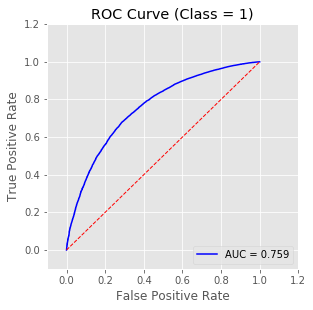

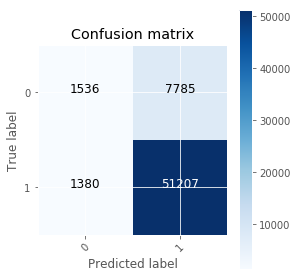

In [304]:
rfc_model = RFC(n_estimators = 350, max_depth = 25, class_weight = 'balanced', random_state = 82, n_jobs = my_n_jobs) 

fit_score_one_model(rfc_model, select_X_train, y_train, select_X_valid, y_valid)

## Naive Bayes

### Tune Model

### Validate Model

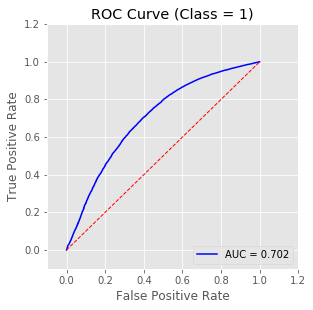

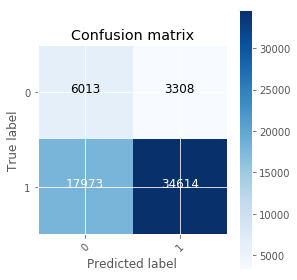

In [305]:
nb_model = NB() 

fit_score_one_model(nb_model, select_X_train, y_train, select_X_valid, y_valid)

## Logistic Regression

### Tune Model

In [306]:
# c_values = [10**x for x in [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]]
# tune_model = LogReg(class_weight = 'balanced', random_state = 82)
# grid_search_model(tune_model, select_X_tune, y_tune, 'C', c_values)

### Validate Model

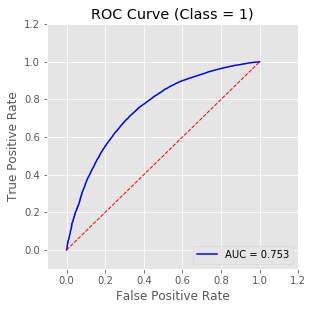

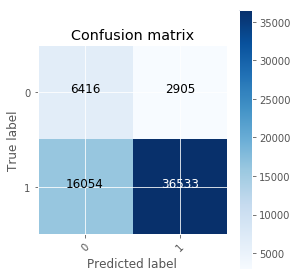

In [307]:
log_reg_model = LogReg(class_weight = 'balanced', C = 10**0.5, penalty = 'l2', random_state = 82) 

fit_score_one_model(log_reg_model, select_X_train, y_train, select_X_valid, y_valid)

## Quadratic Discriminant Analysis

### Tune Model

In [308]:
# reg_param_values = [10**x for x in [-4, -3, -2, -1, 0]]
# tune_model = QDA() 
# grid_search_model(tune_model, select_X_tune, y_tune, 'reg_param', reg_param_values)

In [309]:
# reg_param_values = [0.0005, 0.001, 0.002, 0.004]
# tune_model = QDA() 
# grid_search_model(tune_model, select_X_tune, y_tune, 'reg_param', reg_param_values)

### Validate Model

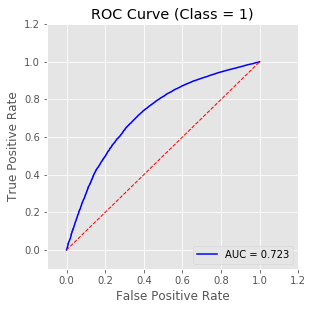

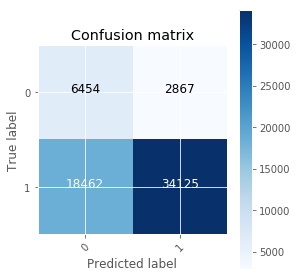

In [310]:
qda_model = QDA(reg_param = 0.001) 

fit_score_one_model(qda_model, select_X_train, y_train, select_X_valid, y_valid)

# Ensemble

In [311]:
# define stacking classifier for use with sklearn API
class StackingClassifier(BaseEstimator, ClassifierMixin):

    models = []
    
    num_models_ = 0
    combiner_ = None

    def __init__(self, models):
        self.models = models
        self.num_models_ = len(models)
        self.combiner_ = LogReg(class_weight = 'balanced', C = 0.005, random_state = 82)

    def internal_models_predict_(self, X):
        internal_models_predict = np.zeros((X.shape[0], self.num_models_))
        for i in range(self.num_models_):
            model = self.models[i] 
            internal_models_predict[:, i] = model.predict_proba(X)[:, 1]
        return(internal_models_predict)

    def fit(self, X, y):
        internal_models_predict = self.internal_models_predict_(X)
        self.combiner_.fit(internal_models_predict, y)        
    
    def predict(self, X):
        internal_models_predict = self.internal_models_predict_(X)
        y_predict = self.combiner_.predict(internal_models_predict)
        return(y_predict)  

    def predict_proba(self, X):
        internal_models_predict = self.internal_models_predict_(X)
        y_predict = self.combiner_.predict_proba(internal_models_predict)
        return(y_predict)    

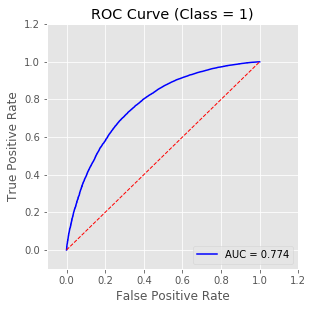

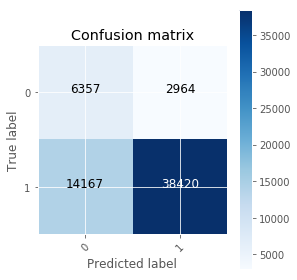

In [312]:
stack_model = StackingClassifier([select_xgb_model, qda_model, nb_model])

fit_score_one_model(stack_model, select_X_train, y_train, select_X_valid, y_valid)

# Predict and Submit

In [313]:
select_X_train_full = np.concatenate([select_X_train, select_X_valid], axis = 0)
y_train_full = np.concatenate([y_train, y_valid], axis = 0)

select_full_xgb_model = my_create_xgb()
_ = select_full_xgb_model.fit(select_X_train_full, y_train_full)

In [314]:
full_testing_data = my_load_data('processed_test_data.csv')
full_prediction_data = full_testing_data.drop('id', axis = 1)
select_prediction_data = selector.transform(full_prediction_data)
test_predict = select_full_xgb_model.predict_proba(select_prediction_data)

V0,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V3,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,W0,W1,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W2,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W3,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W4,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W5,W50,W51,W52,W53,W54,W55,W56,W57,W58,W59,W6,W60,W61,W62,W63,W64,W65,W66,W67,W68,W69,W7,W70,W71,W72,W73,W74,W75,W76,W77,W78,W79,W8,W80,W81,W82,W83,W84,W85,W86,W87,W88,W89,W9,W90,W91,W92,W93,W94,W95,W96,W97,W98,W99,X0,X1,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X2,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X3,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X4,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X5,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X6,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X7,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X9,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y0,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,Y19,Y2,Y20,Y21,Y22,Y23,Y24,Y25,Y26,Y27,Y28,Y29,Y3,Y30,Y31,Y32,Y33,Y34,Y35,Y36,Y37,Y38,Y39,Y4,Y40,Y41,Y42,Y43,Y44,Y45,Y46,Y47,Y48,Y49,Y5,Y50,Y51,Y52,Y53,Y54,Y55,Y56,Y57,Y58,Y59,Y6,Y60,Y61,Y62,Y63,Y64,Y65,Y66,Y67,Y68,Y69,Y7,Y70,Y71,Y72,Y73,Y74,Y75,Y76,Y77,Y78,Y79,Y8,Y80,Y81,Y82,Y83,Y84,Y85,Y86,Y87,Y88,Y89,Y9,Y90,Y91,Y92,Y93,Y94,Y95,Y96,Y97,Y98,Y99,Z0,Z1,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z2,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z3,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,Z38,Z39,Z4,Z40,Z41,Z42,Z43,Z44,Z45,Z46,Z47,Z48,Z49,Z5,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59,Z6,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z7,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z8,Z80,Z81,Z82,Z83,Z84,Z85,Z86,Z87,Z88,Z89,Z9,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,app_sci,applied_learning,care,care_and_hunger,civ_and_gov,college_and_career,comm_serve,cur_price_per_total_apps,date_index,day_of_month,day_of_week,early_dev,econ,env_sci,esl,essay_1_sentiment_polarity,essay_1_sentiment_subjectivity,essay_2_sentiment_polarity,essay_2_sentiment_subjectivity,extracurricular,fin_lit,grade_category,gym_and_fit,health_and_life_sci,health_and_sports,health_and_well,hist_and_civ,hist_and_geo,hour_of_day,id,languages,lit,lit_and_lang,lit_and_writing,math,math_and_sci,median_word_len_1,median_word_len_2,median_word_len_res_descrip,median_word_len_res_sum,median_word_len_title,month_of_year,music,num_categories,num_chars_1,num_chars_2,num_chars_res_descrip,num_chars_res_sum,num_chars_title,num_punctuations_1,num_punctuations_2,num_stopwords_1,num_stopwords_2,num_subcategories,num_unique_words_1,num_unique_words_2,num_unique_words_res_descrip,num_unique_words_res_sum,num_unique_words_title,num_words_1,num_words_2,num_words_res_descrip,num_words_res_sum,num_words_title,nutrition,other,parent_involve,perform_arts,project_max_price,project_max_quantity,project_mean_price,project_mean_quantity,project_min_price,project_min_quantity,project_price,project_price_per_item,project_quantity,project_resource_summary_sentiment_polarity,project_resource_summary_sentiment_subjectivity,project_title_sentiment_polarity,project_title_sentiment_subjectivity,res_description_sentiment_polarity,res_description_sentiment_subjectivity,soc_sci,special_needs,special_needs_2,teacher_max_price,teacher_max_quantity,teacher_mean_price,teacher_mean_quantity,teacher_min_price,teacher_min_quantity,teacher_num_prev_posted_projs,teacher_price,teacher_price_per_item,teacher_quantity,team_sports,vis_arts,warmth,year,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32,S33,S34,S35,S36,S37,S38,S39,S40,S41,S42,S43,S44,S45,S46,S47,S48,S49,S50,S51,S52,S53,S54,S55,S56,P0,P1,P2,P3,P4,P5,G0,G1,G2,G3,G4,G5
0.027919,-0.042289,-0.019289,-0.007364,0.015855,-0.088487,0.02

In [315]:
print(test_predict.shape)

(78035, 2)


In [316]:
test_predict_ones = pd.DataFrame(test_predict[:, 1])
submit_data = pd.concat([full_testing_data.id, test_predict_ones], axis = 1)
submit_data.columns = ['id', 'project_is_approved']
submit_data.to_csv('submission_data.csv', index = False)